In [15]:
!pip install --upgrade transformers
!pip install mysql-connector-python
!pip install sentencepiece
!pip install protobuf

^C


SQL CONNECTION

In [30]:
import mysql.connector

connection = mysql.connector.connect(
  host = "gateway01.ap-southeast-1.prod.aws.tidbcloud.com",
  port = 4000,
  user = "38pAbRBz5Urzj3r.root",
  password = "dXIP2LwlYh0vkTdH",
  database = "equipment_profile",
  ssl_ca = "/etc/ssl/cert.pem",
  ssl_verify_cert = True,
  ssl_verify_identity = True
)
if connection.is_connected():
    print("✅ Connected to TiDB successfully!")
else:
    print("❌ Failed to connect to TiDB")


✅ Connected to TiDB successfully!


Create Vector from MODEL

In [3]:
from transformers import AutoModel, AutoProcessor

processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
model = AutoModel.from_pretrained("google/siglip-base-patch16-224")

/Users/sedtawutchalothornnarumit/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
import os
from PIL import Image
import torch
import numpy as np
import json
from sklearn.model_selection import train_test_split

In [4]:
def process_multi_class_dataset(dataset_path="dataset/", test_size=0.2, random_state=42):
    """
    Process multiple classes from different folders with train/validation split.
    """
    all_train_embeddings = []
    all_val_embeddings = []
    
    # Get all class folders
    class_folders = [f for f in os.listdir(dataset_path) 
                    if os.path.isdir(os.path.join(dataset_path, f))]
    
    print(f"Found {len(class_folders)} classes: {class_folders}")
    
    for class_name in class_folders:
        folder_path = os.path.join(dataset_path, class_name)
        print(f"\n📁 Processing class: {class_name}")
        
        # Get all image files for this class
        image_files = []
        for filename in os.listdir(folder_path):
            if filename.lower().endswith((".jpeg", ".jpg", ".png", ".webp")):
                image_files.append(filename)
        
        if len(image_files) == 0:
            print(f"⚠️ No images found in {folder_path}")
            continue
            
        print(f"Total images found: {len(image_files)}")
        
        # Split into train (80%) and validation (20%) for this class
        train_files, val_files = train_test_split(
            image_files, test_size=test_size, random_state=random_state
        )
        print(f"Training set: {len(train_files)} images")
        print(f"Validation set: {len(val_files)} images")
        
        # Process training files for this class
        class_train_embeddings = []
        for filename in train_files:
            path = os.path.join(folder_path, filename)
            try:
                image = Image.open(path)
                
                # Generate embedding for the image
                inputs = processor(images=image, return_tensors="pt")
                with torch.no_grad():
                    outputs = model.get_image_features(**inputs)
                
                embedding = outputs / outputs.norm(p=2, dim=-1, keepdim=True)  # normalize
                
                # Append embedding with label and file path
                class_train_embeddings.append({
                    "embedding": embedding.squeeze().tolist(),
                    "label": class_name,
                    "file_path": path
                })
            except Exception as e:
                print(f"❌ Error processing training file {filename}: {e}")
        
        # Process validation files for this class
        class_val_embeddings = []
        for filename in val_files:
            path = os.path.join(folder_path, filename)
            try:
                image = Image.open(path)
                
                # Generate embedding for the image
                inputs = processor(images=image, return_tensors="pt")
                with torch.no_grad():
                    outputs = model.get_image_features(**inputs)
                
                embedding = outputs / outputs.norm(p=2, dim=-1, keepdim=True)  # normalize
                
                # Append embedding with label and file path
                class_val_embeddings.append({
                    "embedding": embedding.squeeze().tolist(),
                    "label": class_name,
                    "file_path": path
                })
            except Exception as e:
                print(f"❌ Error processing validation file {filename}: {e}")
        
        # Add to overall collections
        all_train_embeddings.extend(class_train_embeddings)
        all_val_embeddings.extend(class_val_embeddings)
        
        # Calculate summary statistics for this class
        if class_train_embeddings:
            class_train_summary = np.mean([item["embedding"] for item in class_train_embeddings], axis=0)
            print(f"✅ {class_name} training set processed: {len(class_train_embeddings)} embeddings")
        
        if class_val_embeddings:
            class_val_summary = np.mean([item["embedding"] for item in class_val_embeddings], axis=0)
            print(f"✅ {class_name} validation set processed: {len(class_val_embeddings)} embeddings")
    
    print(f"\n🎯 Overall Summary:")
    print(f"Total classes processed: {len(class_folders)}")
    print(f"Total training embeddings: {len(all_train_embeddings)}")
    print(f"Total validation embeddings: {len(all_val_embeddings)}")
    
    return all_train_embeddings, all_val_embeddings

# Process all classes
print("🚀 Starting multi-class dataset processing...")
train_embeddings, val_embeddings = process_multi_class_dataset(dataset_path="dataset/lamp")

# Show class distribution
if train_embeddings:
    train_class_counts = {}
    for emb in train_embeddings:
        label = emb["label"]
        train_class_counts[label] = train_class_counts.get(label, 0) + 1
    
    print(f"\n📊 Training set class distribution:")
    for class_name, count in train_class_counts.items():
        print(f"  {class_name}: {count} images")

if val_embeddings:
    val_class_counts = {}
    for emb in val_embeddings:
        label = emb["label"]
        val_class_counts[label] = val_class_counts.get(label, 0) + 1
    
    print(f"\n📊 Validation set class distribution:")
    for class_name, count in val_class_counts.items():
        print(f"  {class_name}: {count} images")

🚀 Starting multi-class dataset processing...
Found 7 classes: ['AI6', 'AI13', 'AI7', 'AI12', 'AI9', 'AI17', 'AI18']

📁 Processing class: AI6
Total images found: 104
Training set: 83 images
Validation set: 21 images
✅ AI6 training set processed: 83 embeddings
✅ AI6 validation set processed: 21 embeddings

📁 Processing class: AI13
Total images found: 102
Training set: 81 images
Validation set: 21 images
✅ AI13 training set processed: 81 embeddings
✅ AI13 validation set processed: 21 embeddings

📁 Processing class: AI7
Total images found: 112
Training set: 89 images
Validation set: 23 images
✅ AI7 training set processed: 89 embeddings
✅ AI7 validation set processed: 23 embeddings

📁 Processing class: AI12
Total images found: 92
Training set: 73 images
Validation set: 19 images
✅ AI12 training set processed: 73 embeddings
✅ AI12 validation set processed: 19 embeddings

📁 Processing class: AI9
Total images found: 163
Training set: 130 images
Validation set: 33 images
✅ AI9 training set proc

Save on vector db

In [11]:
# Create cursor for database operations
cursor = connection.cursor()

# Clear previous data (optional - remove this if you want to keep existing data)
# cursor.execute("DELETE FROM equipment_embeddings")
# print("🗑️ Cleared existing embeddings from database")

# Only save training embeddings to the database
train_count_by_class = {}
total_train_count = 0

print("💾 Saving training embeddings to database...")

for idx, embedding in enumerate(train_embeddings):
    # Extract the embedding, label, and file path
    embedding_list = embedding["embedding"]
    label = embedding["label"]
    file_path = embedding["file_path"]

    # Insert the embedding into the database
    insert_query = """
    INSERT INTO equipment_embeddings (class_name, image_embedding, path) 
    VALUES (%s, %s, %s)
    """

    # Convert embedding to JSON string
    embedding_json = json.dumps(embedding_list)

    # Execute the insert
    cursor.execute(insert_query, (label, embedding_json, file_path))
    
    # Count by class
    train_count_by_class[label] = train_count_by_class.get(label, 0) + 1
    total_train_count += 1
    
    # Show progress every 50 embeddings
    if (idx + 1) % 50 == 0:
        print(f"Progress: {idx + 1}/{len(train_embeddings)} embeddings saved")

# Commit the transaction
connection.commit()

print(f"\n✅ Training embeddings saved to database successfully!")
print(f"Total training embeddings saved: {total_train_count}")

print(f"\n📊 Training embeddings saved by class:")
for class_name, count in train_count_by_class.items():
    print(f"  {class_name}: {count} embeddings")

print(f"\nValidation embeddings kept for evaluation: {len(val_embeddings)}")

# Close cursor
cursor.close()

# Keep validation embeddings in memory for evaluation
print(f"\n📊 Validation set ready for evaluation:")
print(f"Validation embeddings available in 'val_embeddings' variable")

# Show validation class distribution
val_count_by_class = {}
for emb in val_embeddings:
    label = emb["label"]
    val_count_by_class[label] = val_count_by_class.get(label, 0) + 1

print(f"\n📊 Validation embeddings by class:")
for class_name, count in val_count_by_class.items():
    print(f"  {class_name}: {count} embeddings")

💾 Saving training embeddings to database...
Progress: 50/639 embeddings saved
Progress: 100/639 embeddings saved
Progress: 150/639 embeddings saved
Progress: 200/639 embeddings saved
Progress: 250/639 embeddings saved
Progress: 300/639 embeddings saved
Progress: 350/639 embeddings saved
Progress: 400/639 embeddings saved
Progress: 450/639 embeddings saved
Progress: 500/639 embeddings saved
Progress: 550/639 embeddings saved
Progress: 600/639 embeddings saved

✅ Training embeddings saved to database successfully!
Total training embeddings saved: 639

📊 Training embeddings saved by class:
  AI6: 83 embeddings
  AI13: 81 embeddings
  AI7: 89 embeddings
  AI12: 73 embeddings
  AI9: 130 embeddings
  AI17: 82 embeddings
  AI18: 101 embeddings

Validation embeddings kept for evaluation: 164

📊 Validation set ready for evaluation:
Validation embeddings available in 'val_embeddings' variable

📊 Validation embeddings by class:
  AI6: 21 embeddings
  AI13: 21 embeddings
  AI7: 23 embeddings
  AI1

Evaluation Functions

In [12]:
def evaluate_model_on_validation(val_embeddings, connection, top_k=5):
    """
    Evaluate the model using validation embeddings.
    This function tests how well the model can retrieve similar images from the database
    using validation set images as queries.
    """
    correct_predictions = 0
    total_predictions = len(val_embeddings)
    
    print(f"🔍 Evaluating model on {total_predictions} validation images...")
    
    for i, val_embedding in enumerate(val_embeddings):
        # Use the validation embedding as a query
        query_embedding = val_embedding["embedding"]
        true_label = val_embedding["label"]
        
        # Search in the database (which only contains training data)
        cur = connection.cursor()
        sql = """
        SELECT class_name, path, 
               vec_cosine_distance(image_embedding, %s) AS distance
        FROM equipment_embeddings
        ORDER BY distance ASC
        LIMIT %s;
        """
        cur.execute(sql, (json.dumps(query_embedding), top_k))
        results = cur.fetchall()
        cur.close()
        
        # Check if the top result matches the true label
        if results and results[0][0] == true_label:
            correct_predictions += 1
        
        # Print progress every 10 images
        if (i + 1) % 10 == 0:
            print(f"Progress: {i + 1}/{total_predictions}")
    
    # Calculate accuracy
    accuracy = correct_predictions / total_predictions * 100
    
    print(f"\n📈 Evaluation Results:")
    print(f"Correct predictions: {correct_predictions}/{total_predictions}")
    print(f"Accuracy: {accuracy:.2f}%")
    
    return accuracy, correct_predictions, total_predictions

def evaluate_single_validation_image(val_embedding, connection, top_k=5, show_results=True):
    """
    Evaluate a single validation image and optionally show the top-k results.
    """
    query_embedding = val_embedding["embedding"]
    true_label = val_embedding["label"]
    true_path = val_embedding["file_path"]
    
    # Search in the database
    cur = connection.cursor()
    sql = """
    SELECT class_name, path, 
           vec_cosine_distance(image_embedding, %s) AS distance
    FROM equipment_embeddings
    ORDER BY distance ASC
    LIMIT %s;
    """
    cur.execute(sql, (json.dumps(query_embedding), top_k))
    results = cur.fetchall()
    cur.close()
    
    if show_results:
        print(f"🔍 Query image: {true_path} (True label: {true_label})")
        print(f"Top {top_k} similar images from training set:")
        for i, (class_name, path, distance) in enumerate(results, 1):
            print(f"{i}. {class_name} - {path} (Distance: {distance:.4f})")
        
        # Check if prediction is correct
        if results and results[0][0] == true_label:
            print("✅ Correct prediction!")
        else:
            print("❌ Incorrect prediction!")
    
    return results

In [19]:
val_embeddings[30]

{'embedding': [0.00999145582318306,
  0.005636109039187431,
  -0.015741651877760887,
  -0.012561262585222721,
  0.013491141609847546,
  -0.0045211235992610455,
  -0.04264356568455696,
  0.011754568666219711,
  0.009394015185534954,
  -0.008598537184298038,
  -0.034180108457803726,
  -0.022763526067137718,
  0.0003152881981804967,
  -0.04315571114420891,
  0.04794676601886749,
  0.018598522990942,
  0.0004804178315680474,
  0.018340732902288437,
  -0.010301368311047554,
  -0.02002836763858795,
  -0.00132858008146286,
  0.004363843705505133,
  -0.017565108835697174,
  -0.01152846310287714,
  0.011091613210737705,
  0.004461731296032667,
  -0.002792836632579565,
  -0.0027391051407903433,
  -0.02408241108059883,
  -0.005921161733567715,
  -0.020677225664258003,
  0.0019129830179736018,
  -0.009094078093767166,
  -0.022882815450429916,
  0.0005069212638773024,
  0.005463782232254744,
  0.012885595671832561,
  0.0014607246266677976,
  -0.016165511682629585,
  0.04157884418964386,
  0.0279272

In [26]:
evaluate_single_validation_image(val_embedding=val_embeddings[0], connection=connection)

🔍 Query image: dataset/lamp/AI6/20251112_110133.jpg (True label: AI6)
Top 5 similar images from training set:
1. AI6 - dataset/lamp/AI6/20251112_110137.jpg (Distance: 0.0463)
2. AI6 - dataset/lamp/AI6/20251112_110132.jpg (Distance: 0.0483)
3. AI6 - dataset/lamp/AI6/20251112_110129.jpg (Distance: 0.0493)
4. AI6 - dataset/lamp/AI6/20251112_110134.jpg (Distance: 0.0500)
5. AI6 - dataset/lamp/AI6/20251112_110031(0).jpg (Distance: 0.0527)
✅ Correct prediction!


[('AI6', 'dataset/lamp/AI6/20251112_110137.jpg', 0.046261040127870245),
 ('AI6', 'dataset/lamp/AI6/20251112_110132.jpg', 0.04829491911934014),
 ('AI6', 'dataset/lamp/AI6/20251112_110129.jpg', 0.04931788861053987),
 ('AI6', 'dataset/lamp/AI6/20251112_110134.jpg', 0.04995156671391188),
 ('AI6', 'dataset/lamp/AI6/20251112_110031(0).jpg', 0.05270280338615263)]

In [ ]:
# Example: Evaluate on a random validation image
if val_embeddings:
    import random
    random_val_image = random.choice(val_embeddings)
    print("📝 Example evaluation on a random validation image:")
    evaluate_single_validation_image(random_val_image, connection)

In [24]:
# Run full evaluation on multi-class validation set
if val_embeddings:
    print("🚀 Running full multi-class validation evaluation...")
    accuracy, correct, total = evaluate_model_on_validation(val_embeddings, connection, top_k=5)
    
    # Calculate per-class accuracy
    class_correct = {}
    class_total = {}
    class_accuracy = {}
    
    print(f"\n🔍 Calculating per-class accuracy...")
    
    for val_embedding in val_embeddings:
        query_embedding = val_embedding["embedding"]
        true_label = val_embedding["label"]
        
        # Initialize counters
        if true_label not in class_total:
            class_total[true_label] = 0
            class_correct[true_label] = 0
        
        class_total[true_label] += 1
        
        # Search in the database
        cur = connection.cursor()
        sql = """
        SELECT class_name, path, 
               vec_cosine_distance(image_embedding, %s) AS distance
        FROM equipment_embeddings
        ORDER BY distance ASC
        LIMIT 1;
        """
        cur.execute(sql, (json.dumps(query_embedding),))
        result = cur.fetchone()
        cur.close()
        
        if result and result[0] == true_label:
            class_correct[true_label] += 1
    
    # Calculate per-class accuracy
    for class_name in class_total:
        class_accuracy[class_name] = (class_correct[class_name] / class_total[class_name]) * 100
    
    print(f"\n🎯 Final Multi-Class Evaluation Summary:")
    print(f"Overall validation accuracy: {accuracy:.2f}%")
    print(f"Overall correct predictions: {correct}/{total}")
    
    print(f"\n📊 Per-Class Results:")
    for class_name in sorted(class_accuracy.keys()):
        acc = class_accuracy[class_name]
        print(f"  {class_name}: {acc:.2f}% ({class_correct[class_name]}/{class_total[class_name]})")
    
    # Overall performance assessment
    print(f"\n🏆 Performance Assessment:")
    if accuracy >= 90:
        print("🏆 Excellent overall performance!")
    elif accuracy >= 70:
        print("👍 Good overall performance!")
    elif accuracy >= 50:
        print("⚠️ Average performance - consider model improvements")
    else:
        print("🔴 Poor performance - needs significant improvement")
    
    # Find best and worst performing classes
    if class_accuracy:
        best_class = max(class_accuracy, key=class_accuracy.get)
        worst_class = min(class_accuracy, key=class_accuracy.get)
        
        print(f"\n📈 Class Performance:")
        print(f"Best performing: {best_class} ({class_accuracy[best_class]:.2f}%)")
        print(f"Worst performing: {worst_class} ({class_accuracy[worst_class]:.2f}%)")
        
        # Show which classes might be confused
        print(f"\n🔄 Classes to investigate:")
        for class_name, acc in class_accuracy.items():
            if acc < 80:
                print(f"  {class_name}: {acc:.2f}% - may need more training data or better features")
    
else:
    print("❌ No validation embeddings available for evaluation")

🚀 Running full multi-class validation evaluation...
🔍 Evaluating model on 164 validation images...
Progress: 10/164
Progress: 20/164
Progress: 30/164
Progress: 40/164
Progress: 50/164
Progress: 60/164
Progress: 70/164
Progress: 80/164
Progress: 90/164
Progress: 100/164
Progress: 110/164
Progress: 120/164
Progress: 130/164
Progress: 140/164
Progress: 150/164
Progress: 160/164

📈 Evaluation Results:
Correct predictions: 164/164
Accuracy: 100.00%

🔍 Calculating per-class accuracy...

🎯 Final Multi-Class Evaluation Summary:
Overall validation accuracy: 100.00%
Overall correct predictions: 164/164

📊 Per-Class Results:
  AI12: 100.00% (19/19)
  AI13: 100.00% (21/21)
  AI17: 100.00% (21/21)
  AI18: 100.00% (26/26)
  AI6: 100.00% (21/21)
  AI7: 100.00% (23/23)
  AI9: 100.00% (33/33)

🏆 Performance Assessment:
🏆 Excellent overall performance!

📈 Class Performance:
Best performing: AI6 (100.00%)
Worst performing: AI6 (100.00%)

🔄 Classes to investigate:


Search Functions

In [34]:
def search_similar_images_from_path(image_path, connection, top_k=5, show_image=True, show_results=True):
    """
    Search for similar images in the database using an image file path.
    
    Args:
        image_path (str): Path to the query image file
        connection: Database connection object
        top_k (int): Number of similar images to return
        show_image (bool): Whether to display the query image
        show_results (bool): Whether to print the results
    
    Returns:
        list: List of tuples (class_name, path, distance)
    """
    try:
        # Load and display the query image
        image = Image.open(image_path)
        
        if show_image:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(8, 6))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Query Image: {os.path.basename(image_path)}")
            plt.show()
        
        # Generate embedding for the query image
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            query_embedding = model.get_image_features(**inputs)
        
        # Normalize the embedding
        query_embedding = query_embedding / query_embedding.norm(p=2, dim=-1, keepdim=True)
        query_embedding_list = query_embedding.squeeze().tolist()

        # Search in the database
        cur = connection.cursor()
        sql = """
        SELECT class_name, path, 
               vec_cosine_distance(image_embedding, %s) AS distance
        FROM equipment_embeddings
        ORDER BY distance ASC
        LIMIT %s;
        """
        cur.execute(sql, (json.dumps(query_embedding_list), top_k))
        results = cur.fetchall()
        cur.close()

        if show_results:
            print(f"🔍 Query: {image_path}")
            print(f"📊 Top {top_k} similar images:")
            print("-" * 60)
            
            for i, (class_name, path, distance) in enumerate(results, 1):
                confidence = (1 - distance) * 100  # Convert distance to confidence percentage
                print(f"{i}. Class: {class_name}")
                print(f"   Path: {path}")
                print(f"   Confidence: {confidence:.2f}% (Distance: {distance:.4f})")
                print()
            
            # Show prediction
            if results:
                predicted_class = results[0][0]
                confidence = (1 - results[0][2]) * 100
                print(f"🎯 Predicted Class: {predicted_class} (Confidence: {confidence:.2f}%)")
            else:
                print("❌ No similar images found in database")

        return [(class_name, path, distance) for class_name, path, distance in results]
        
    except Exception as e:
        print(f"❌ Error processing image {image_path}: {e}")
        return []

def batch_search_from_folder(folder_path, connection, top_k=3, max_images=10):
    """
    Search for similar images for multiple files in a folder.
    
    Args:
        folder_path (str): Path to folder containing test images
        connection: Database connection object
        top_k (int): Number of similar images to return per query
        max_images (int): Maximum number of images to process
    
    Returns:
        dict: Results for each processed image
    """
    results = {}
    processed = 0
    
    print(f"🔍 Batch searching images in: {folder_path}")
    print(f"Processing up to {max_images} images...")
    print("=" * 60)
    
    # Get all image files in the folder
    image_files = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpeg", ".jpg", ".png", ".webp")):
            image_files.append(filename)
    
    print(f"Found {len(image_files)} images in folder")
    
    for filename in image_files[:max_images]:
        if processed >= max_images:
            break
            
        image_path = os.path.join(folder_path, filename)
        print(f"\n📸 Processing: {filename}")
        
        # Search without showing individual results
        search_results = search_similar_images_from_path(
            image_path, connection, top_k=top_k, 
            show_image=False, show_results=False
        )
        
        if search_results:
            predicted_class = search_results[0][0]
            confidence = (1 - search_results[0][2]) * 100
            print(f"   Prediction: {predicted_class} ({confidence:.1f}% confidence)")
            
            results[filename] = {
                'predicted_class': predicted_class,
                'confidence': confidence,
                'top_results': search_results
            }
        else:
            print(f"   ❌ No results found")
            results[filename] = None
        
        processed += 1
    
    print(f"\n✅ Batch search completed. Processed {processed} images.")
    return results

def search_with_confidence_threshold(image_path, connection, confidence_threshold=70.0, top_k=5):
    """
    Search with confidence filtering - only return results above threshold.
    
    Args:
        image_path (str): Path to query image
        connection: Database connection object
        confidence_threshold (float): Minimum confidence percentage (0-100)
        top_k (int): Maximum number of results to consider
    
    Returns:
        dict: Search results with confidence filtering
    """
    results = search_similar_images_from_path(
        image_path, connection, top_k=top_k, 
        show_image=True, show_results=False
    )
    
    if not results:
        return {"status": "no_results", "message": "No similar images found"}
    
    # Filter by confidence threshold
    filtered_results = []
    for class_name, path, distance in results:
        confidence = (1 - distance) * 100
        if confidence >= confidence_threshold:
            filtered_results.append((class_name, path, distance, confidence))
    
    if filtered_results:
        print(f"🎯 High-confidence results (≥{confidence_threshold}%):")
        print("-" * 50)
        for i, (class_name, path, distance, confidence) in enumerate(filtered_results, 1):
            print(f"{i}. {class_name}: {confidence:.1f}% confidence")
        
        best_match = filtered_results[0]
        return {
            "status": "confident",
            "predicted_class": best_match[0],
            "confidence": best_match[3],
            "all_confident_results": filtered_results
        }
    else:
        best_result = results[0]
        best_confidence = (1 - best_result[2]) * 100
        print(f"⚠️ Low confidence prediction:")
        print(f"Best match: {best_result[0]} ({best_confidence:.1f}% confidence)")
        
        return {
            "status": "low_confidence",
            "predicted_class": best_result[0],
            "confidence": best_confidence,
            "message": f"Highest confidence ({best_confidence:.1f}%) below threshold ({confidence_threshold}%)"
        }

Example Usage - Search from Path

🔍 Single Image Search:


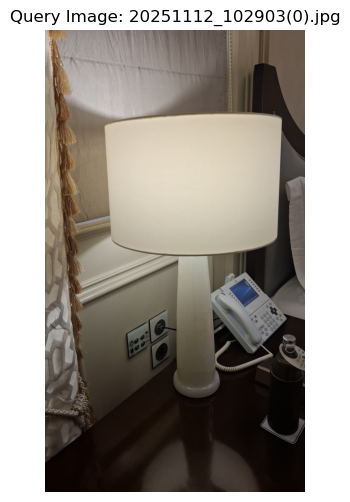

🔍 Query: dataset/lamp/AI18/20251112_102903(0).jpg
📊 Top 5 similar images:
------------------------------------------------------------
1. Class: AI18
   Path: dataset/lamp/AI18/20251112_102903(0).jpg
   Confidence: 100.00% (Distance: 0.0000)

2. Class: AI18
   Path: dataset/lamp/AI18/20251112_102903.jpg
   Confidence: 98.99% (Distance: 0.0101)

3. Class: AI18
   Path: dataset/lamp/AI18/20251112_102907.jpg
   Confidence: 98.10% (Distance: 0.0190)

4. Class: AI18
   Path: dataset/lamp/AI18/20251112_102905.jpg
   Confidence: 97.93% (Distance: 0.0207)

5. Class: AI18
   Path: dataset/lamp/AI18/20251112_102906.jpg
   Confidence: 97.16% (Distance: 0.0284)

🎯 Predicted Class: AI18 (Confidence: 100.00%)


In [36]:
# Example 1: Search for a single image from testset
test_image_path = "dataset/lamp/AI18/20251112_102903(0).jpg"
print("🔍 Single Image Search:")
results = search_similar_images_from_path(test_image_path, connection, top_k=5)

In [ ]:
# Example 2: Batch search multiple images from testset
print("\n" + "="*60)
print("🔍 Batch Search from Testset:")
batch_results = batch_search_from_folder("testset/", connection, top_k=3, max_images=5)

# Show summary of batch results
print("\n📊 Batch Search Summary:")
for filename, result in batch_results.items():
    if result:
        print(f"  {filename}: {result['predicted_class']} ({result['confidence']:.1f}%)")
    else:
        print(f"  {filename}: No results")

In [ ]:
# Example 3: Search with confidence threshold
print("\n" + "="*60)
print("🔍 High-Confidence Search:")
confidence_result = search_with_confidence_threshold(
    "testset/maltese.jpg", 
    connection, 
    confidence_threshold=75.0, 
    top_k=5
)

print(f"\nSearch Result Status: {confidence_result['status']}")
if confidence_result['status'] == 'confident':
    print(f"High-confidence prediction: {confidence_result['predicted_class']} ({confidence_result['confidence']:.1f}%)")
elif confidence_result['status'] == 'low_confidence':
    print(f"Low-confidence prediction: {confidence_result['predicted_class']} ({confidence_result['confidence']:.1f}%)")
    print(f"Message: {confidence_result['message']}")